In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

def plot_columns_by_frequency(
    df, columns, 
    freq='D', 
    ignore_datetimes=False, 
    vertical_lines=None,
    line_text=None
):
    """
    Plot columns from a dataframe based on specified frequency.
    
    df: pandas DataFrame with a datetime index
    columns: list of columns to plot
    freq: frequency for plotting ('D' for day, 'W' for week, 'M' for month, 'Y' for year, or integer if ignore_datetimes=True)
    ignore_datetimes: if True, plots against a dummy index instead of datetimes
    vertical_lines: list of 2-tuple with datetimes indicating positions for vertical lines. 
                    The first datetime is plotted as a red line and the second as a green line.
    """

    if ignore_datetimes:
        if isinstance(freq, int):
            num_points = freq
        else:
            raise ValueError("When ignore_datetimes=True, freq should be an integer representing number of points.")
        
        indices = list(range(0, len(df), num_points))
        if indices[-1] != len(df):
            indices.append(len(df))

        for start, end in zip(indices[:-1], indices[1:]):
            subset = df.iloc[start:end]
            plt.figure(figsize=(10, 6))
            subset[columns].plot(ax=plt.gca(), marker='.', linestyle='--', secondary_y=True)
            
            if vertical_lines:
                for line in vertical_lines:
                    if df.index[start] <= line[0] <= df.index[end-1]:
                        idx_before = df.index.get_loc(line[0], method='ffill')
                        idx_after = df.index.get_loc(line[0], method='bfill')
                        pos = (idx_before + idx_after) / 2 - start
                        plt.axvline(x=pos, color='red')
                    
                    if df.index[start] <= line[1] <= df.index[end-1]:
                        idx_before = df.index.get_loc(line[1], method='ffill')
                        idx_after = df.index.get_loc(line[1], method='bfill')
                        pos = (idx_before + idx_after) / 2 - start
                        plt.axvline(x=pos, color='green')
            
            plt.title(f'Data from {subset.index[0]} to {subset.index[-1]}')
            plt.show()

    else:
        for sub_df in df.resample(freq):
            label, subset = sub_df
            if not subset.empty:
                plt.figure(figsize=(10, 6))
                subset[columns].plot(ax=plt.gca(), marker='.', linestyle='--', secondary_y=True)
                if vertical_lines:
                    for (line_idx, line) in enumerate(vertical_lines):
                        line_plotted=False
                        if subset.index[0] <= line[0] <= subset.index[-1]:
                            plt.axvline(x=line[0], color='red')
                            line_plotted=True
                        if subset.index[0] <= line[1] <= subset.index[-1]:
                            plt.axvline(x=line[1], color='green')
                            line_plotted=True
                        if line_plotted and len(line_text) == len(vertical_lines):
                            print(f'line:{line_idx}, reason:{line_text[line_idx]}')
                            
                plt.title(f'Data from {subset.index[0]} to {subset.index[-1]}')
                plt.show()

In [2]:
def is_start_of_daily_block(date_series):
    """
    Returns a boolean Series indicating if each date in the input Series is the 
    start of a new sequence of consecutive dates.

    :param date_series: Pandas Series with datetime objects.
    :return: Pandas Series of boolean values.
    """
    # Ensure the Series is sorted
    sorted_series = date_series.sort_values()

    # Calculate the difference in days between each date and the previous date
    day_diff = sorted_series.diff().dt.days

    # Mark True where the difference is greater than 1 day, indicating a new sequence
    is_start = day_diff > 1

    # Handle the first element
    if not is_start.empty:
        is_start.iloc[0] = True

    return is_start

In [3]:
def clean_data(df):
    df = df[(df['Extruder Pressure'] >= 0) & (df['Extruder Pressure'] < 50000)]
    
    return df

In [4]:
def get_machine_pauses(df, time_threshold=30, index=True):
    if index:
        time_diff = -1*(df.index.diff(-1).dt.total_seconds()/60)
        machine_pauses = df[time_diff > time_threshold].index
    else:
        time_diff = -1*(df['Date and Time'].diff(-1).dt.total_seconds()/60)
        machine_pauses = df[time_diff > time_threshold]['Date and Time']
    
    return machine_pauses

def calculate_time_difference(df, time_threshold=30):
    time_diff = -1*(df['Date and Time'].diff(-1).dt.total_seconds()/60)
    #time_diff = (df['Date and Time'].shift(-1) - df['Date and Time']).dt.total_seconds()/60

    return time_diff

In [5]:
import utils

In [6]:
def clean_extruder_data(extruder_data):
    
    extruder_data = extruder_data.drop(extruder_data.index[0])
    extruder_data = extruder_data.replace("<null>", None)
    
    extruder_data = extruder_data.dropna()

    # Convert the column to string type
    for column in extruder_data.columns:
        if column not in ["Date and Time", "AnomalyScore"]:
            extruder_data[column] = extruder_data[column].astype(str)
            #extruder_data[column] = extruder_data[column].str.replace("<null>", None)
            # Replace commas with an empty string
            extruder_data[column] = extruder_data[column].str.replace(",", "")

            # Convert the column back to numeric type, handling any conversion errors
            extruder_data[column] = pd.to_numeric(extruder_data[column], errors="coerce")
            
    extruder_data = extruder_data[(extruder_data['Extruder Pressure'] >= 0) & \
                              (extruder_data['Extruder Pressure'] < 50000)]

    extruder_data['Date and Time'] = pd.to_datetime(extruder_data['Date and Time'])
    
    return extruder_data

In [7]:
import pandas as pd
import re

columns_oi = ['Extruder Pressure']

ex3_data = clean_extruder_data( pd.read_csv("ex3-data.csv") )

/tmp/ipykernel_33025/3693725319.py:6: DtypeWarning: Columns (2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  ex3_data = clean_extruder_data( pd.read_csv("ex3-data.csv") )


In [8]:

ex3_data = ex3_data.groupby('Date and Time').mean()

# resampling every 5 minutes instead of 1 minute

ex3_resampled = ex3_data.resample('5T').mean()

In [9]:

ex3_data['Date and Time'] = ex3_data.index
ex3_pauses = get_machine_pauses(ex3_data, time_threshold=15, index=False)

pauses = ex3_pauses

In [10]:
ex3_data.head()

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%),Date and Time
Date and Time,,,,,,,,,
2022-11-08 08:41:00,3855.95,27.04,19.64,12.16,53.42,4.79,0.925,75.4,2022-11-08 08:41:00
2022-11-08 08:42:00,3965.45,27.04,19.64,12.16,54.28,4.79,0.910,75.4,2022-11-08 08:42:00
2022-11-08 08:45:00,3965.45,27.04,19.64,12.16,54.28,0.00,0.910,75.4,2022-11-08 08:45:00
2022-11-08 08:47:00,3564.65,27.04,19.64,12.16,54.28,0.00,0.910,75.4,2022-11-08 08:47:00
2022-11-08 08:48:00,3564.65,27.04,19.64,12.16,54.28,5.01,0.910,75.4,2022-11-08 08:48:00


In [11]:
def hours_since_last_pause(time, pauses):
    return (time - pauses[pauses <= time].max()).total_seconds()/3600

def hours_to_next_pause(time, pauses):
    return (pauses[pauses >= time].min() - time).total_seconds()/3600

In [12]:
%%time
#from tqdm import tqdm

ex3_data['hours_since_last_pause'] = ex3_data.index.to_series().apply(
    lambda x : hours_since_last_pause(x, pauses)
)
ex3_data['hours_to_next_pause'] = ex3_data.index.to_series().apply(
    lambda x : hours_to_next_pause(x, pauses)
)

CPU times: user 41.3 s, sys: 32.2 ms, total: 41.3 s
Wall time: 41.3 s


In [13]:
# Extruder Pressure - for rolling
# for lagged variables - Extruder Die Temp, Extruder Thrust

#test = ex1_data.iloc[:1000][['Extruder Pressure']]


for time_window in ['5T', '15T', '30T', '1H', '2H', '3H', '6H', '12H']:
    if 'T' in time_window:
        label_append = time_window.replace('T', 'min')
    elif 'H' in time_window:
        label_append = time_window.replace('H', 'hour')

    col_label = 'pressure-' + label_append + '_avg'
    ex3_data[col_label] = ex3_data['Extruder Pressure'].rolling(time_window).mean()

In [14]:
variables_to_lag = ['Extruder Die Temp', 'Extruder Thrust']

colname_map = {
    'Extruder Die Temp' : 'die_temp-',
    'Extruder Thrust' : 'thrust-',
}
#ex_num = 1

#print(ex_num, ex3_data.shape)
for time_window in ['5T', '15T', '1H', '3H']:
    if 'T' in time_window:
        label_append = time_window.replace('T', 'min')
    elif 'H' in time_window:
        label_append = time_window.replace('H', 'hour')
    for lagvar in variables_to_lag:
        col_label = colname_map[lagvar] + label_append + '_avg'
        ex3_data[col_label] = \
            ex3_data[lagvar].rolling(time_window).mean()

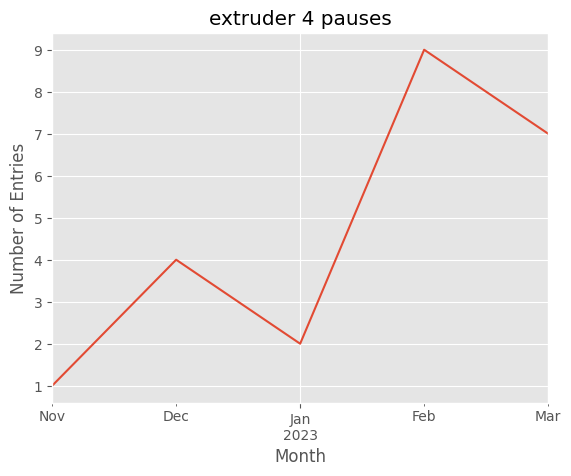

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_entries_by_frequency(
    datetime_series, 
    title='Number of entries by month',
    freq='M',
    kind='line',
):
    monthly_counts = datetime_series.groupby(pd.Grouper(freq=freq)).count()

    monthly_counts.plot(kind=kind)
    plt.xlabel('Month')
    plt.ylabel('Number of Entries')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_entries_by_frequency(ex3_pauses, title='extruder 4 pauses')

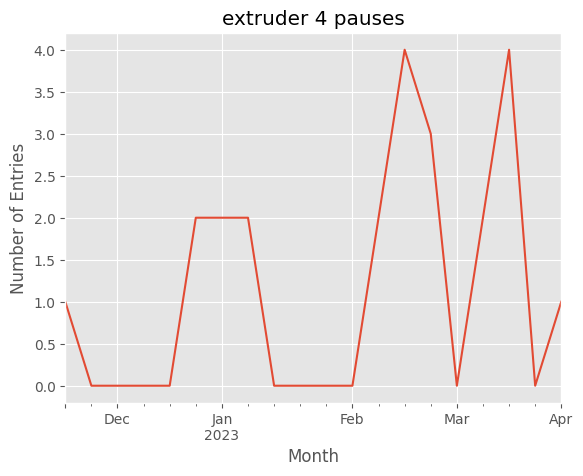

In [16]:
plot_entries_by_frequency(ex3_pauses, title='extruder 4 pauses', freq='W')

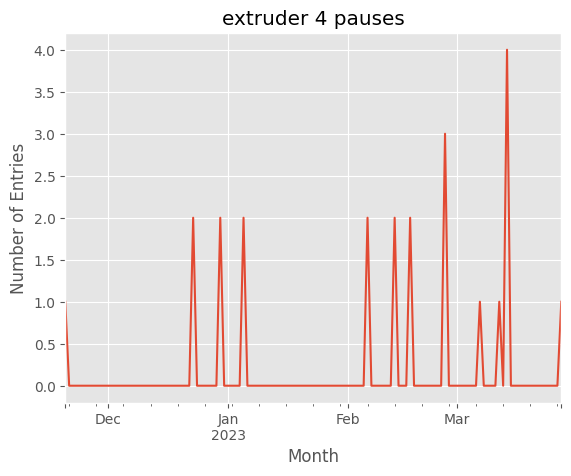

In [17]:

plot_entries_by_frequency(
    ex3_pauses, 
    title='extruder 4 pauses', freq='D'
)

In [18]:
min_datetime = pauses.min() - pd.Timedelta(days=7)
max_datetime = pauses.max()

time_mask = (ex3_data.index >= min_datetime) \
            & (ex3_data.index <= max_datetime)
ex3_data = ex3_data[time_mask]

redundancy_mask = (ex3_data['hours_since_last_pause'] >= 3) \
                  | (ex3_data['hours_to_next_pause'] >= 3)
ex3_data = ex3_data[redundancy_mask]

In [19]:
# set up classifier variables -
# whether there is a pause within 
# {1 minute, 5 minutes, 10 minutes, 15 minutes, 30 minutes,
#  1 hour, 2 hours, 3 hours, 6 hours, 12 hours, 24 hours}

stop_target_to_hours_map = {
#    '1min' : 1/60,
    '5min' : 5/60,
    '10min': 10/60,
    '15min': 15/60,
    '30min': 30/60,
    '1hour': 1,
    '2hour': 2,
    '3hour': 3,
    '6hour':6,
    '12hour':12,
    '24hour':24,
}


for window in stop_target_to_hours_map:
    ex3_data[f'{window}_stop'] = \
        ex3_data['hours_to_next_pause'] < stop_target_to_hours_map[window]

In [20]:
target_features = [s+ '_stop' for s in stop_target_to_hours_map.keys()]
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-5min_avg',
    'pressure-15min_avg',
    'pressure-30min_avg',
    'pressure-1hour_avg',
    'pressure-2hour_avg',
    'pressure-3hour_avg',
    'die_temp-5min_avg',
    'thrust-5min_avg',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'die_temp-3hour_avg',
    'thrust-3hour_avg',
]

In [21]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

def balance_dataset(X, y, over_sample_ratio=0.1, under_sample_ratio=0.5):
    """
    Balances the dataset by over-sampling the minority class and under-sampling the majority class.

    :param X: Feature set.
    :param y: Labels.
    :param over_sample_ratio: Ratio of the number of samples in the minority class after resampling
                              to the number of samples in the majority class before resampling.
    :param under_sample_ratio: Ratio of the number of samples in the majority class after resampling
                               to the number of samples in the minority class after over-sampling.

    :return: Balanced features and labels.
    """
    
    # Define the resampling strategy
    over = SMOTE(sampling_strategy=over_sample_ratio)
    under = RandomUnderSampler(sampling_strategy=under_sample_ratio)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)

    # Transform the dataset
    X_balanced, y_balanced = pipeline.fit_resample(X, y)

    return X_balanced, y_balanced

In [22]:
model_input = ex3_data[input_features]
model_output = ex3_data[target_features]

In [23]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns

import time

# Load a dataset (Iris dataset as an example)
#data = load_iris()
X = model_input.values
#y = model_output.values

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models to test
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'MLP' : MLPClassifier(hidden_layer_sizes=(16, 32), max_iter=1000)
}

# Dictionary to hold the results
results = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
for targ in target_features:
    if targ not in results:
        start_time = time.time()
        
        results[targ] = dict()
    y = model_output[targ].values
    
    
    
    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    n_true = np.sum((Y_train == 1))
    n_false = np.sum((Y_train == 0))
    print(f'original true samples: {n_true}, original false samples: {n_false}')
    X_train, Y_train = balance_dataset(X_train, Y_train)
    
    saved_processed_data[targ] = (X_train, Y_train)
    
    n_true = np.sum((Y_train == 1))
    n_false = np.sum((Y_train == 0))
    print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
    for name, model in models.items():
        print()
        print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
        print(f'results for target: {targ}, model: {model}')
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        # Compute the confusion matrix
        conf_matrix = confusion_matrix(Y_test, predictions)

        # Visualize the confusion matrix
        #plt.figure(figsize=(10, 7))
        #sns.heatmap(conf_matrix, annot=True, fmt='g')
        #plt.xlabel('Predicted labels')
        #plt.ylabel('True labels')
        #plt.title('Confusion Matrix')
        #plt.show()
        accuracy = accuracy_score(Y_test, predictions)
        cross_val = cross_val_score(model, X, y, cv=5)
        results[targ][name] = {'Accuracy': accuracy, 'Cross-Val Mean': np.mean(cross_val),
                              'Confusion_Matrix' : conf_matrix}
        
        
        print(results[targ][name])
        print('--------------------------------------')
        
        duration = time.time() - start_time
        print(f"Run time: {duration / 60:.2f} minutes")
        print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
        print('--------------------------------------')
        
    results_df = pd.DataFrame(results[targ]).T
    #print(results_df)
    print()
    print()

# Convert results to DataFrame for better visualization
#results_df = pd.DataFrame(results).T
#print(results_df)


original true samples: 15, original false samples: 77693
balanced true samples: 7769, balanced false samples: 15538

Current Time: 19:37:54
results for target: 5min_stop, model: LogisticRegression()


/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.8993720403541281, 'Cross-Val Mean': 0.9996499738084974, 'Confusion_Matrix': array([[17469,  1954],
       [    1,     4]])}
--------------------------------------
Run time: 0.09 minutes
Current Time: 19:38:00
--------------------------------------

Current Time: 19:38:00
results for target: 5min_stop, model: RandomForestClassifier()
{'Accuracy': 0.9998970557957587, 'Cross-Val Mean': 0.9920317105666177, 'Confusion_Matrix': array([[19422,     1],
       [    1,     4]])}
--------------------------------------
Run time: 0.86 minutes
Current Time: 19:38:46
--------------------------------------

Current Time: 19:38:46
results for target: 5min_stop, model: SVC()
{'Accuracy': 0.9594399835289273, 'Cross-Val Mean': 0.9997941031130736, 'Confusion_Matrix': array([[18637,   786],
       [    2,     3]])}
--------------------------------------
Run time: 1.22 minutes
Current Time: 19:39:08
--------------------------------------

Current Time: 19:39:08
results for target: 5min_stop, m

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.9332406835495162, 'Cross-Val Mean': 0.9994955522031083, 'Confusion_Matrix': array([[18128,  1294],
       [    3,     3]])}
--------------------------------------
Run time: 0.08 minutes
Current Time: 19:42:24
--------------------------------------

Current Time: 19:42:24
results for target: 10min_stop, model: RandomForestClassifier()
{'Accuracy': 0.9993823347745522, 'Cross-Val Mean': 0.9864415551886438, 'Confusion_Matrix': array([[19411,    11],
       [    1,     5]])}
--------------------------------------
Run time: 1.04 minutes
Current Time: 19:43:21
--------------------------------------

Current Time: 19:43:21
results for target: 10min_stop, model: SVC()
{'Accuracy': 0.9655651636812848, 'Cross-Val Mean': 0.9995470269547425, 'Confusion_Matrix': array([[18756,   666],
       [    3,     3]])}
--------------------------------------
Run time: 1.47 minutes
Current Time: 19:43:47
--------------------------------------

Current Time: 19:43:47
results for target: 10min_stop

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.9407041383570105, 'Cross-Val Mean': 0.9991352315911817, 'Confusion_Matrix': array([[18267,  1148],
       [    4,     9]])}
--------------------------------------
Run time: 0.08 minutes
Current Time: 19:47:18
--------------------------------------

Current Time: 19:47:18
results for target: 15min_stop, model: RandomForestClassifier()
{'Accuracy': 0.9991764463660696, 'Cross-Val Mean': 0.9839090000577488, 'Confusion_Matrix': array([[19400,    15],
       [    1,    12]])}
--------------------------------------
Run time: 1.16 minutes
Current Time: 19:48:23
--------------------------------------

Current Time: 19:48:23
results for target: 15min_stop, model: SVC()
{'Accuracy': 0.9762713609223801, 'Cross-Val Mean': 0.9993102457467383, 'Confusion_Matrix': array([[18960,   455],
       [    6,     7]])}
--------------------------------------
Run time: 1.61 minutes
Current Time: 19:48:50
--------------------------------------

Current Time: 19:48:50
results for target: 15min_stop

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.9217624047766111, 'Cross-Val Mean': 0.9984454778678227, 'Confusion_Matrix': array([[17893,  1514],
       [    6,    15]])}
--------------------------------------
Run time: 0.08 minutes
Current Time: 19:52:27
--------------------------------------

Current Time: 19:52:27
results for target: 30min_stop, model: RandomForestClassifier()
{'Accuracy': 0.9987646695491044, 'Cross-Val Mean': 0.9621866628166054, 'Confusion_Matrix': array([[19383,    24],
       [    0,    21]])}
--------------------------------------
Run time: 1.36 minutes
Current Time: 19:53:44
--------------------------------------

Current Time: 19:53:44
results for target: 30min_stop, model: SVC()
{'Accuracy': 0.960366481367099, 'Cross-Val Mean': 0.9985381324207646, 'Confusion_Matrix': array([[18647,   760],
       [   10,    11]])}
--------------------------------------
Run time: 2.96 minutes
Current Time: 19:55:20
--------------------------------------

Current Time: 19:55:20
results for target: 30min_stop,

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.8811509162034178, 'Cross-Val Mean': 0.9959129354545933, 'Confusion_Matrix': array([[17093,  2279],
       [   30,    26]])}
--------------------------------------
Run time: 0.10 minutes
Current Time: 19:59:10
--------------------------------------

Current Time: 19:59:10
results for target: 1hour_stop, model: RandomForestClassifier()
{'Accuracy': 0.9991764463660696, 'Cross-Val Mean': 0.9240850664941558, 'Confusion_Matrix': array([[19357,    15],
       [    1,    55]])}
--------------------------------------
Run time: 1.40 minutes
Current Time: 20:00:28
--------------------------------------

Current Time: 20:00:28
results for target: 1hour_stop, model: SVC()
{'Accuracy': 0.9494543957175211, 'Cross-Val Mean': 0.997014495139568, 'Confusion_Matrix': array([[18425,   947],
       [   35,    21]])}
--------------------------------------
Run time: 3.16 minutes
Current Time: 20:02:13
--------------------------------------

Current Time: 20:02:13
results for target: 1hour_stop,

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.8922174181593576, 'Cross-Val Mean': 0.9923920952967752, 'Confusion_Matrix': array([[17296,  2012],
       [   82,    38]])}
--------------------------------------
Run time: 0.08 minutes
Current Time: 20:06:00
--------------------------------------

Current Time: 20:06:00
results for target: 2hour_stop, model: RandomForestClassifier()
{'Accuracy': 0.9990735021618283, 'Cross-Val Mean': 0.895804868680617, 'Confusion_Matrix': array([[19290,    18],
       [    0,   120]])}
--------------------------------------
Run time: 1.26 minutes
Current Time: 20:07:11
--------------------------------------

Current Time: 20:07:11
results for target: 2hour_stop, model: SVC()
{'Accuracy': 0.9370496191064444, 'Cross-Val Mean': 0.9938642731935168, 'Confusion_Matrix': array([[18170,  1138],
       [   85,    35]])}
--------------------------------------
Run time: 3.15 minutes
Current Time: 20:09:04
--------------------------------------

Current Time: 20:09:04
results for target: 2hour_stop,

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.8515544574840437, 'Cross-Val Mean': 0.9902919556345505, 'Confusion_Matrix': array([[16451,  2790],
       [   94,    93]])}
--------------------------------------
Run time: 0.08 minutes
Current Time: 20:13:07
--------------------------------------

Current Time: 20:13:07
results for target: 3hour_stop, model: RandomForestClassifier()
{'Accuracy': 0.9989190858554663, 'Cross-Val Mean': 0.889782355063468, 'Confusion_Matrix': array([[19220,    21],
       [    0,   187]])}
--------------------------------------
Run time: 1.09 minutes
Current Time: 20:14:08
--------------------------------------

Current Time: 20:14:08
results for target: 3hour_stop, model: SVC()
{'Accuracy': 0.9366378422894791, 'Cross-Val Mean': 0.9908890627535089, 'Confusion_Matrix': array([[18137,  1104],
       [  127,    60]])}
--------------------------------------
Run time: 1.99 minutes
Current Time: 20:15:02
--------------------------------------

Current Time: 20:15:02
results for target: 3hour_stop,

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.874768375540457, 'Cross-Val Mean': 0.9703198558613693, 'Confusion_Matrix': array([[16867,  2172],
       [  261,   128]])}
--------------------------------------
Run time: 0.07 minutes
Current Time: 20:19:05
--------------------------------------

Current Time: 20:19:05
results for target: 6hour_stop, model: RandomForestClassifier()
{'Accuracy': 0.9981984764257772, 'Cross-Val Mean': 0.885623296342837, 'Confusion_Matrix': array([[19007,    32],
       [    3,   386]])}
--------------------------------------
Run time: 1.24 minutes
Current Time: 20:20:15
--------------------------------------

Current Time: 20:20:15
results for target: 6hour_stop, model: SVC()
{'Accuracy': 0.9582561251801524, 'Cross-Val Mean': 0.9808104102444444, 'Confusion_Matrix': array([[18531,   508],
       [  303,    86]])}
--------------------------------------
Run time: 3.08 minutes
Current Time: 20:22:06
--------------------------------------

Current Time: 20:22:06
results for target: 6hour_stop, 

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.8889746757257566, 'Cross-Val Mean': 0.9361923096085174, 'Confusion_Matrix': array([[16958,  1682],
       [  475,   313]])}
--------------------------------------
Run time: 0.08 minutes
Current Time: 20:26:20
--------------------------------------

Current Time: 20:26:20
results for target: 12hour_stop, model: RandomForestClassifier()
{'Accuracy': 0.9980440601194153, 'Cross-Val Mean': 0.8657748101599608, 'Confusion_Matrix': array([[18603,    37],
       [    1,   787]])}
--------------------------------------
Run time: 1.12 minutes
Current Time: 20:27:23
--------------------------------------

Current Time: 20:27:23
results for target: 12hour_stop, model: SVC()
{'Accuracy': 0.9342186534898085, 'Cross-Val Mean': 0.9600148246648823, 'Confusion_Matrix': array([[18029,   611],
       [  667,   121]])}
--------------------------------------
Run time: 7.15 minutes
Current Time: 20:33:25
--------------------------------------

Current Time: 20:33:25
results for target: 12hour_s

KeyboardInterrupt: 